## Starbucks Marketing Strategy Project
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this project was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

The task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$


In [3]:
# load in packages
from itertools import combinations

from test_results import test_results, score
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [4]:
train_data.shape

(84534, 10)

In [5]:
test_data = pd.read_csv('./Test.csv')
test_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,2,No,0,1,41.376390,1.172517,1,1,2,2
1,6,Yes,0,1,25.163598,0.653050,2,2,2,2
2,7,Yes,0,1,26.553778,-1.597972,2,3,4,2
3,10,No,0,2,28.529691,-1.078506,2,3,2,2
4,12,No,0,2,32.378538,0.479895,2,2,1,2


In [6]:
test_data.shape

(41650, 10)

In [7]:
train_data["Promotion"].unique()

array(['No', 'Yes'], dtype=object)

In [8]:
# converting promotion column string to numeric
train_data["Promotion"]=pd.factorize(train_data["Promotion"])[0]

In [9]:
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,0,0,2,30.443518,-1.165083,1,1,3,2
1,3,0,0,3,32.159350,-0.645617,2,3,2,2
2,4,0,0,2,30.431659,0.133583,1,1,4,2
3,5,0,0,0,26.588914,-0.212728,2,1,4,2
4,8,1,0,3,28.044332,-0.385883,1,1,2,2


In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
ID           84534 non-null int64
Promotion    84534 non-null int64
purchase     84534 non-null int64
V1           84534 non-null int64
V2           84534 non-null float64
V3           84534 non-null float64
V4           84534 non-null int64
V5           84534 non-null int64
V6           84534 non-null int64
V7           84534 non-null int64
dtypes: float64(2), int64(8)
memory usage: 6.4 MB


### Creting new columns for different stuations

In [11]:
# columns are created for the calculation of IRR and NIR.

""" 
these columns are:

number of purchasers in the promotion group, 
total number of customers in the purchasers group (treatment),
the number of purchasers in the non-promotional group,
the total number of customers in the non-promotional group (control)
"""

train_data["purc_treat"]=np.where((train_data["Promotion"]==1) & (train_data["purchase"]==1), 1, 0)
train_data["cust_treat"]=np.where(train_data["Promotion"]==1, 1, 0)
train_data["purc_ctrl"]=np.where((train_data["Promotion"]==0) & (train_data["purchase"]==1), 1, 0)
train_data["cust_ctrl"]=np.where(train_data["Promotion"]==0, 1, 0)

In [12]:
# a column is created which is covering all stuations 
# Promotion purchase - no purchase and control purchase - no purchase
train_data["purc_det"]=np.where((train_data["Promotion"]==1) & (train_data["purchase"]==1), 1, 
                                np.where((train_data["Promotion"]==1) & (train_data["purchase"]==0), 2, 
                                         np.where((train_data["Promotion"]==0) & (train_data["purchase"]==1), 3, 
                                                  np.where((train_data["Promotion"]==0) & (train_data["purchase"]==0), 4,0))))

In [13]:
# a column is created which is covering promotion purchase, control purchase and total number of no purchase
train_data["purch_sep"]=np.where((train_data["Promotion"]==1) & (train_data["purchase"]==1), 1, 
                                np.where((train_data["Promotion"]==0) & (train_data["purchase"]==1), 2, 0))

In [14]:
train_data["purch_sep"].unique()

array([0, 1, 2])

In [15]:
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,purc_treat,cust_treat,purc_ctrl,cust_ctrl,purc_det,purch_sep
0,1,0,0,2,30.443518,-1.165083,1,1,3,2,0,0,0,1,4,0
1,3,0,0,3,32.159350,-0.645617,2,3,2,2,0,0,0,1,4,0
2,4,0,0,2,30.431659,0.133583,1,1,4,2,0,0,0,1,4,0
3,5,0,0,0,26.588914,-0.212728,2,1,4,2,0,0,0,1,4,0
4,8,1,0,3,28.044332,-0.385883,1,1,2,2,0,1,0,0,2,0


In [16]:
train_data["purch_sep"].value_counts()

0    83494
1      721
2      319
Name: purch_sep, dtype: int64

In [17]:
train_data["purc_treat"].sum()

721

In [18]:
train_data["purchase"][(train_data["Promotion"]==1) & (train_data["purchase"]==1)].count()

721

In [19]:
train_data["cust_treat"].sum()

42364

In [20]:
train_data["purc_ctrl"].sum()

319

In [21]:
train_data["cust_ctrl"].sum()

42170

In [22]:
train_data["purc_det"].value_counts()

4    41851
2    41643
1      721
3      319
Name: purc_det, dtype: int64

### Data analysis and data visualization

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff598b06828>,
      dtype=object)

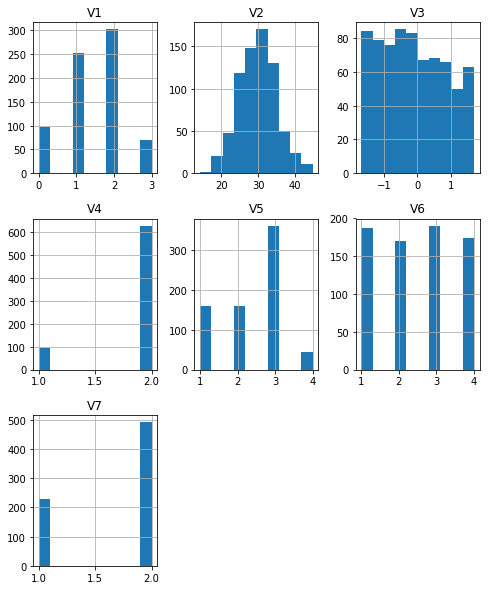

In [23]:
train_data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']][train_data["purc_treat"]==1].hist(figsize=(8,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff598880550>,
      dtype=object)

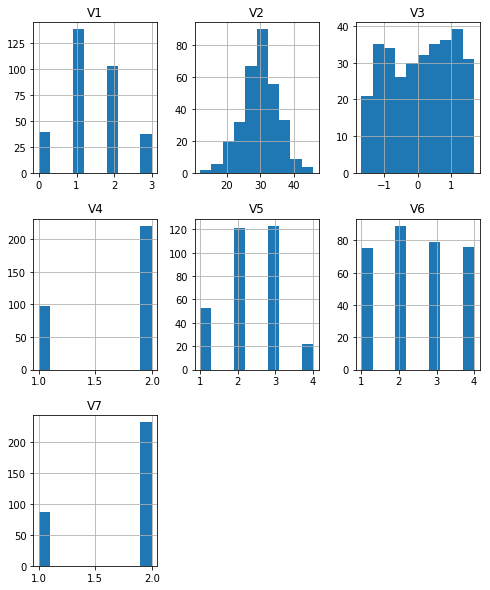

In [24]:
train_data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']][train_data["purc_ctrl"]==1].hist(figsize=(8,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff5985162b0>,
      dtype=object)

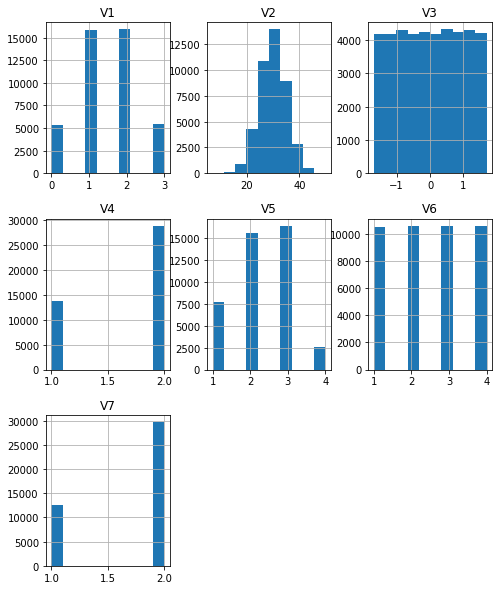

In [25]:
train_data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']][train_data["cust_treat"]==1].hist(figsize=(8,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff5981af208>,
      dtype=object)

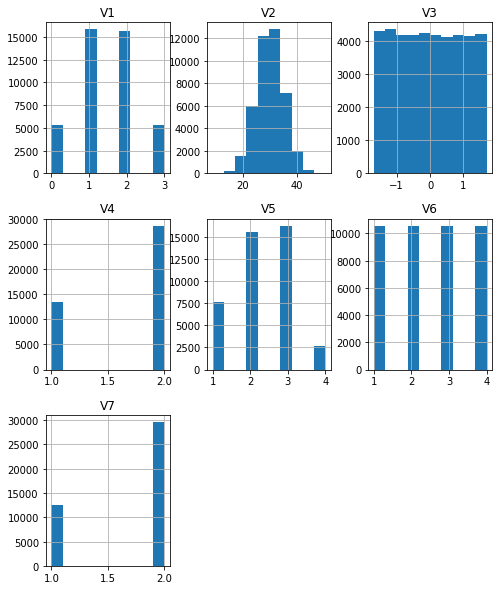

In [26]:
train_data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']][train_data["cust_ctrl"]==1].hist(figsize=(8,10))

### Calculation of IRR and NIR

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$

In [27]:
IRR=(train_data["purc_treat"].sum()/train_data["cust_treat"].sum())-(train_data["purc_ctrl"].sum()/train_data["cust_ctrl"].sum())

In [28]:
IRR

0.009454547819772702

* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

In [29]:
NIR=(10*train_data["purc_treat"].sum() - 0.15*train_data["cust_treat"].sum())-10*train_data["purc_ctrl"].sum()

In [30]:
NIR

-2334.5999999999995

### Model 1

In this model, lets see what is the result if we send the promotion to every customer.

In [31]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    
    promotion=np.array(["Yes" for i in range(test_data.shape[0])])
       
    
    return promotion

In [32]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0096.

Your nir with this strategy is -1132.20.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.009593158278250108, -1132.1999999999998)

### Model 2

In this model I created a ML model which is trained for two labels
1. number of purchasers in the promotion group
2. all the rest

Result:
<br> When we look the confusion matrix we cannot predict purchase group because the dataset is very imbalanced. Number of purchase group is very small according to number of all non purcase group. So, our result is not very good in terms of IRR and NIR score.

In [365]:
train_data.columns

Index(['ID', 'Promotion', 'purchase', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7',
       'purc_treat', 'cust_treat', 'purc_ctrl', 'cust_ctrl', 'purc_det',
       'purch_sep'],
      dtype='object')

In [366]:
X=train_data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
y=train_data["purc_treat"]

In [367]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [368]:
from sklearn import preprocessing
mm_scaler = preprocessing.MinMaxScaler()
X_train_mm = mm_scaler.fit_transform(X_train)
X_test_mm = mm_scaler.transform(X_test)

In [267]:
clf=RandomForestClassifier(random_state=0)
clf.fit(X_train_mm, y_train)
clf.score(X_test_mm, y_test)

0.9915618469303261

[Text(0,0.5,'No Purchase'), Text(0,1.5,'Purchase')]

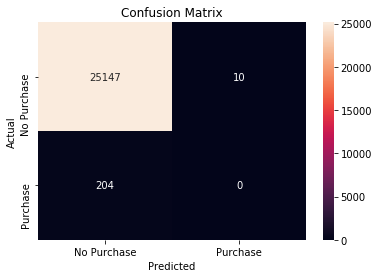

In [268]:
# confusion matrix
cm = sk.metrics.confusion_matrix(y_test, clf.predict(X_test_mm))

fig, ax= plt.subplots()
sns.heatmap(cm, annot=True, fmt='g', ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['No Purchase', 'Purchase']) 
ax.yaxis.set_ticklabels(['No Purchase', 'Purchase'])

In [269]:
print(classification_report(y_test, clf.predict(X_test_mm)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     25157
           1       0.00      0.00      0.00       204

    accuracy                           0.99     25361
   macro avg       0.50      0.50      0.50     25361
weighted avg       0.98      0.99      0.99     25361



In [270]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    df_scaled=mm_scaler.transform(df)
    results=clf.predict(df_scaled)
    
    promotion=[]
    for i in results:
        if i==0:
            promotion.append("No")
        else:
            promotion.append("Yes")
       
    
    return np.array(promotion)

In [271]:
test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0000.

Your nir with this strategy is -1.65.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.0, -1.65)

### Model 3

In this model, I used SMOTE from imblearn to oversample the minority instances and make it equal to majority class.

Result:
<br>According confusion matrix our results are better. I was able to predict purchasers in the promotion group. However, IRR and NIR was lower than previous one.

In [272]:
from imblearn.over_sampling import SMOTE

In [369]:
sm = SMOTE(random_state=0)
X_train_sm, y_train_sm = sm.fit_sample(X_train_mm, y_train)

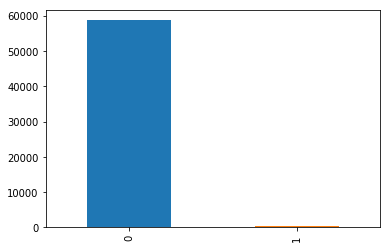

In [274]:
y_train.value_counts().plot.bar()

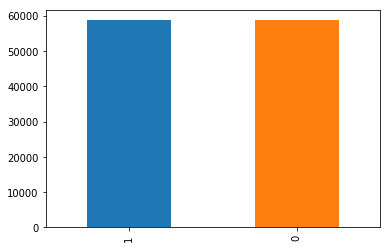

In [275]:
y_train_sm.value_counts().plot.bar()

In [276]:
clf=RandomForestClassifier(random_state=0)
clf.fit(X_train_sm, y_train_sm)

RandomForestClassifier(random_state=0)

In [277]:
clf.score(X_test_mm, y_test)

0.954221048065928

[Text(0,0.5,'No Purchase'), Text(0,1.5,'Purchase')]

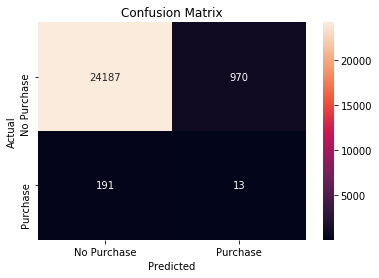

In [278]:
# confusion matrix
cm = sk.metrics.confusion_matrix(y_test, clf.predict(X_test_mm))

fig, ax= plt.subplots()
sns.heatmap(cm, annot=True, fmt='g', ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['No Purchase', 'Purchase']) 
ax.yaxis.set_ticklabels(['No Purchase', 'Purchase'])

In [279]:
print(classification_report(y_test, clf.predict(X_test_mm)))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98     25157
           1       0.01      0.06      0.02       204

    accuracy                           0.95     25361
   macro avg       0.50      0.51      0.50     25361
weighted avg       0.98      0.95      0.97     25361



In [280]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    df_scaled=mm_scaler.transform(df)
    results=clf.predict(df_scaled)
    
    promotion=[]
    for i in results:
        if i==0:
            promotion.append("No")
        else:
            promotion.append("Yes")
       
    
    return np.array(promotion)

In [281]:
test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0098.

Your nir with this strategy is -41.20.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.00976433904369107, -41.19999999999999)

### Model 4

I tried xgboost which is another decision tree model like random forest. Again, I used oversampling method on same dataset in this model.

Result:
<br>Both confusion matrix and IRR-NIR are much better than any other model that I created.
<br>*Best result

In [370]:
import xgboost as xgb

In [371]:
eval_set = [(X_train_sm, y_train_sm), (X_test_mm,y_test)]
clf = xgb.XGBClassifier(seed=42)
clf.fit(X_train_sm, y_train_sm, eval_set=eval_set,\
          eval_metric="auc", verbose=True, early_stopping_rounds=30)

/opt/conda/lib/python3.6/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.78857	validation_1-auc:0.65289
[1]	validation_0-auc:0.82113	validation_1-auc:0.66211
[2]	validation_0-auc:0.83816	validation_1-auc:0.65503
[3]	validation_0-auc:0.85095	validation_1-auc:0.66397
[4]	validation_0-auc:0.87523	validation_1-auc:0.66415
[5]	validation_0-auc:0.88151	validation_1-auc:0.66003
[6]	validation_0-auc:0.89208	validation_1-auc:0.65691
[7]	validation_0-auc:0.90020	validation_1-auc:0.65636
[8]	validation_0-auc:0.90977	validation_1-auc:0.65538
[9]	validation_0-auc:0.91170	validation_1-auc:0.65297
[10]	validation_0-auc:0.92253	validation_1-auc:0.65543
[11]	validation_0-auc:0.92353	validation_1-auc:0.64912
[12]	validation_0-auc:0.92477	validation_1-auc:0.64792
[13]	validation_0-auc:0.93683	validation_1-auc:0.64550
[14]	validation_0-auc:0.94931	validation_1-auc:0.64296
[15]	validation_0-auc:0.95527	validation_1-auc:0.64477
[16]	validation_0-auc:0.95761	validation_1-auc:0.64257
[17]	validation_0-auc:0.95944	validation_1-auc:0.64455
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

[Text(0,0.5,'No Purchase'), Text(0,1.5,'Purchase')]

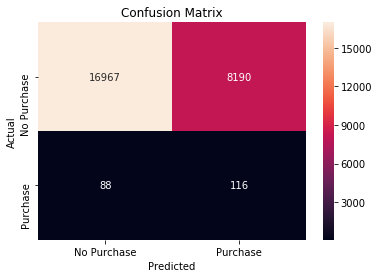

In [372]:
# confusion matrix
cm = sk.metrics.confusion_matrix(y_test, clf.predict(X_test_mm))

fig, ax= plt.subplots()
sns.heatmap(cm, annot=True, fmt='g', ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['No Purchase', 'Purchase']) 
ax.yaxis.set_ticklabels(['No Purchase', 'Purchase'])

In [373]:
print(classification_report(y_test, clf.predict(X_test_mm)))

              precision    recall  f1-score   support

           0       0.99      0.67      0.80     25157
           1       0.01      0.57      0.03       204

    accuracy                           0.67     25361
   macro avg       0.50      0.62      0.42     25361
weighted avg       0.99      0.67      0.80     25361



In [374]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    df_scaled=mm_scaler.transform(df)
    results=clf.predict(df_scaled)
    
    promotion=[]
    for i in results:
        if i==1:
            promotion.append("Yes")
        else:
            promotion.append("No")
       
    
    return np.array(promotion)

In [375]:
test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0194.

Your nir with this strategy is 277.00.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.019425822445774777, 277.0)

### Model 5

In this model, I changed dataset. I create labels for:

1. number of purchasers in the promotion group
2. number of non-purchasers in the promotion group
3. number of purchasers in the control group
4. number of non-purchasers in the control group

Again I used SMOTE to oversample the minority group.

Result:
<br> The confusion matrix is doesn't look very succesful. However, IRR and NIR is second best result in my models.

In [338]:
X=train_data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
y=train_data["purc_det"]

In [339]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [340]:
mm_scaler = preprocessing.MinMaxScaler()
X_train_mm = mm_scaler.fit_transform(X_train)
X_test_mm = mm_scaler.transform(X_test)

In [341]:
sm = SMOTE(random_state=0)
X_train_sm, y_train_sm = sm.fit_sample(X_train_mm, y_train)

In [342]:
clf=RandomForestClassifier(random_state=0)
clf.fit(X_train_sm, y_train_sm)
clf.score(X_test_mm, y_test)

0.4700524427270218

[Text(0,0.5,'pro pur'),
 Text(0,1.5,'pro no pur'),
 Text(0,2.5,'ctrl pur'),
 Text(0,3.5,'ctrl no pur')]

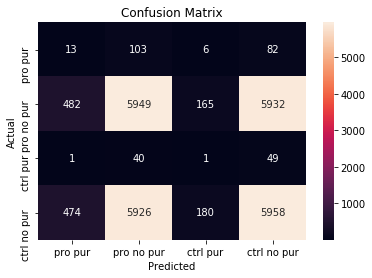

In [344]:
# confusion matrix
cm = sk.metrics.confusion_matrix(y_test, clf.predict(X_test_mm))

fig, ax= plt.subplots()
sns.heatmap(cm, annot=True, fmt='g', ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(["pro pur", "pro no pur", "ctrl pur", "ctrl no pur"])
ax.yaxis.set_ticklabels(["pro pur", "pro no pur", "ctrl pur", "ctrl no pur"])

In [343]:
print(classification_report(y_test, clf.predict(X_test_mm)))

              precision    recall  f1-score   support

           1       0.01      0.06      0.02       204
           2       0.50      0.47      0.48     12528
           3       0.00      0.01      0.00        91
           4       0.50      0.48      0.49     12538

    accuracy                           0.47     25361
   macro avg       0.25      0.26      0.25     25361
weighted avg       0.49      0.47      0.48     25361



In [345]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    df_scaled=mm_scaler.transform(df)
    results=clf.predict(df_scaled)
    
    promotion=[]
    for i in results:
        if i==1:
            promotion.append("Yes")
        else:
            promotion.append("No")
       
    
    return np.array(promotion)

In [346]:
test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0195.

Your nir with this strategy is 33.90.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.019498195159476893, 33.900000000000006)

### Model 6

I trained my ML model with the dataset which is containing two labels:

1. total number of purchasers
2. total number of non-purchasers

Result:
<br> Confusion matrix is better than model 3 however IRR-NIR scores are lower in this model.

In [347]:
X=train_data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
y=train_data["purchase"]

In [348]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [349]:
mm_scaler = preprocessing.MinMaxScaler()
X_train_mm = mm_scaler.fit_transform(X_train)
X_test_mm = mm_scaler.transform(X_test)

In [350]:
sm = SMOTE(random_state=0)
X_train_sm, y_train_sm = sm.fit_sample(X_train_mm, y_train)

In [351]:
clf=RandomForestClassifier(random_state=0)
clf.fit(X_train_sm, y_train_sm)
clf.score(X_test_mm, y_test)

0.932376483577146

[Text(0,0.5,'No Purchase'), Text(0,1.5,'Purchase')]

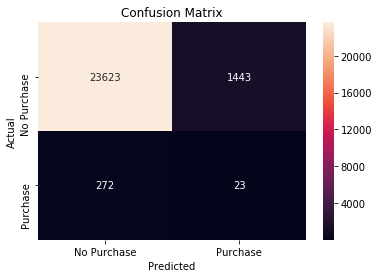

In [352]:
# confusion matrix
cm = sk.metrics.confusion_matrix(y_test, clf.predict(X_test_mm))

fig, ax= plt.subplots()
sns.heatmap(cm, annot=True, fmt='g', ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['No Purchase', 'Purchase']) 
ax.yaxis.set_ticklabels(['No Purchase', 'Purchase'])

In [353]:
print(classification_report(y_test, clf.predict(X_test_mm)))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96     25066
           1       0.02      0.08      0.03       295

    accuracy                           0.93     25361
   macro avg       0.50      0.51      0.50     25361
weighted avg       0.98      0.93      0.95     25361



In [354]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    df_scaled=mm_scaler.transform(df)
    results=clf.predict(df_scaled)
    
    promotion=[]
    for i in results:
        if i==1:
            promotion.append("Yes")
        else:
            promotion.append("No")
       
    
    return np.array(promotion)

In [355]:
test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0115.

Your nir with this strategy is -51.15.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.01154204900231953, -51.150000000000006)

### Model 7

In this model, I trained my ML model with the dataset which is consist of 3 labels:

1. number of purchasers in the promotion group
2. the number of purchasers in the control group
3. non-purchasers

Result:
There isn't any improvement in results.

In [356]:
X=train_data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
y=train_data["purch_sep"]

In [357]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [358]:
mm_scaler = preprocessing.MinMaxScaler()
X_train_mm = mm_scaler.fit_transform(X_train)
X_test_mm = mm_scaler.transform(X_test)

In [359]:
sm = SMOTE(random_state=0)
X_train_sm, y_train_sm = sm.fit_sample(X_train_mm, y_train)

In [360]:
clf=RandomForestClassifier(random_state=0)
clf.fit(X_train_sm, y_train_sm)
clf.score(X_test_mm, y_test)

0.9415638184614171

[Text(0,0.5,'no purch'), Text(0,1.5,'pro purch'), Text(0,2.5,'ctrl purch')]

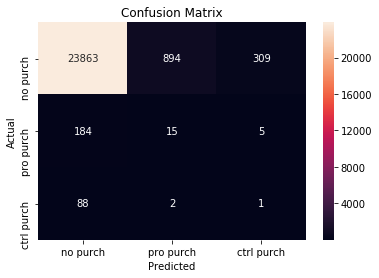

In [361]:
# confusion matrix
cm = sk.metrics.confusion_matrix(y_test, clf.predict(X_test_mm))

fig, ax= plt.subplots()
sns.heatmap(cm, annot=True, fmt='g', ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(["no purch", "pro purch", "ctrl purch"])
ax.yaxis.set_ticklabels(["no purch", "pro purch", "ctrl purch"])

In [362]:
print(classification_report(y_test, clf.predict(X_test_mm)))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     25066
           1       0.02      0.07      0.03       204
           2       0.00      0.01      0.00        91

    accuracy                           0.94     25361
   macro avg       0.34      0.35      0.33     25361
weighted avg       0.98      0.94      0.96     25361



In [363]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    df_scaled=mm_scaler.transform(df)
    results=clf.predict(df_scaled)
    
    promotion=[]
    for i in results:
        if i==0:
            promotion.append("No")
        else:
            promotion.append("Yes")
       
    
    return np.array(promotion)

In [364]:
test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0078.

Your nir with this strategy is -74.30.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.0077548434122139305, -74.29999999999998)